# 과제1: tensorflow를 이용한 NN 밑바닥부터 구현
input feature가 100개이고,  
hidden layer가 2개이고 neuron이 각각 50,10개이고,  
output이 5개인 NN를 구현해 보자  
* hidden layer는 relu를 activation function으로, output layer는 softmax를 activation function으로 사용

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
n_x = 100
n_h1 = 50
n_h2 = 10
n_y = 5

In [3]:
# Simulate train set
m = 500

x_train=np.random.randn(m,n_x).astype(np.float32)
y_train=np.zeros((m,n_y)).astype(np.float32)
y_train[np.arange(m),np.random.randint(n_y,size=m)]=1

print(x_train)
print(y_train)

[[-0.38237816  1.0253665  -0.3196254  ... -0.46716237  0.77819324
   0.63510406]
 [ 1.1000122  -0.45601788  1.7574004  ...  0.2110379   0.31037498
   0.4572011 ]
 [ 0.17211288 -0.17638448  0.1188924  ...  0.44172284  0.07289919
  -0.8421886 ]
 ...
 [-0.8548751   0.30479956 -0.7082259  ...  0.1761828  -0.5257288
  -0.8661318 ]
 [ 0.12430654 -2.617837    0.620999   ...  0.29080206  1.1509986
   1.8239413 ]
 [-1.041141   -1.7609707  -0.28504065 ...  0.01006519 -1.6656154
  -0.5609093 ]]
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


* Initialization of weights

In [4]:
w1=tf.Variable(1e-3*np.random.randn(n_x,n_h1).astype(np.float32),name="w1")
## 코드를 작성해 보세요 ##
w2=tf.Variable(1e-3*np.random.randn(n_h1, n_h2).astype(np.float32), name='w2')
w3=tf.Variable(1e-3*np.random.randn(n_h2, n_y).astype(np.float32), name='w3')

* forward propagation을 통해 prediction 값을 구하고, loss를 구하는 function을 만들어 봅시다

In [5]:
def forward(x):
    z1=tf.matmul(x,w1)
    a1=tf.nn.relu(z1)
    ## 코드를 작성해 보세요 ##
    z2=tf.matmul(a1, w2)
    a2=tf.nn.relu(z2)
    z3=tf.matmul(a2, w3)
    predictions = tf.nn.softmax(z3)
    
    return predictions

def loss_fn(predictions, y):
    loss= -tf.reduce_sum(y*tf.math.log(predictions))
    return loss    

* backpropagation & update parameters

In [6]:
learning_rate=1e-2
optimizer=tf.keras.optimizers.Adam(learning_rate)

def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = forward(x)
        loss = loss_fn(predictions, y)
    ## 코드를 작성해 보세요 ## (hint: tape.gradient를 구글링 해보세요)
    gradient = tape.gradient(loss, [w1, w2, w3])
    # optimizer와 위에서 구한 경사도를 이용해 가중치들을 업데이트 합니다.
    optimizer.apply_gradients(zip(gradient, [w1, w2, w3]))
    return loss, w1, w2, w3


* 간단하게 train loop를 작성해 loss가 줄어나가는지 확인해 봅시다.

In [8]:
loss_list = []

for step in range(10): 
    loss, w1, w2, w3 = train_step(x_train, y_train)
    loss_list.append(loss.numpy())
    
print(loss_list)

[744.5835, 729.59393, 716.53937, 703.2638, 687.1472, 668.62665, 649.5781, 630.59314, 611.46216, 591.16846]


# 과제2: MNIST 데이터를 나만의 NN model로 95 % 이상의 성능으로 training 시켜보자!


## Loading MNIST training data

In [9]:
from tensorflow import keras

# import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Loading the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Scaling(image data는 min-max scaling 주로 사용)
x_train = x_train/255.0
x_test = x_test/255.0

## Training Data
28 * 28 pixel 값을 가진 총 60000개의 이미지 데이터

In [10]:
x_train.shape 

(60000, 28, 28)

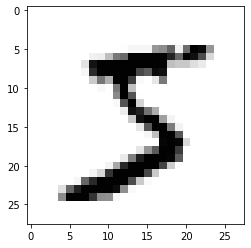

In [11]:
plt.imshow(x_train[0]).set_cmap('Greys')

Neural network 모델에 맞게 이미지 데이터를 벡터 형태로 데이터를 reshape 합니다.  
(Model을 만들 때 *keras.layers.Flatten(input_shape=(28, 28)) 이용해도 됨)

In [12]:
x_train, x_test = x_train.reshape((-1, 28*28)), x_test.reshape((-1, 28*28))
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

## Training Labels
이미지 데이터가 나타내는 숫자값을 label로 가지고 있고, 0부터 9까지의 값을 나타냄  
마찬가지로, 60000개의 label이 존재

In [13]:
y_train.shape

(60000,)

In [14]:
# show MNIST label for above data
y_train[0]

5

## 나만의 모델을 tensorflow keras API 를 이용해 만들어 봅시다~

* parameters for model

In [15]:
activation_list = ["sigmoid", "relu", "softmax", "tanh"]

loss_list = ["sparse_categorical_crossentropy",
             "categorical_crossentropy", 
             "binary_crossentropy"]

optimizer_list = ["sgd", "adam", "rmsprop", "adagrad"]

initializer_list = [tf.keras.initializers.RandomNormal(), 
                    tf.keras.initializers.RandomUniform(), 
                    tf.keras.initializers.he_normal(), 
                    tf.keras.initializers.he_uniform(), 
                    tf.keras.initializers.GlorotUniform(),
                    tf.keras.initializers.GlorotNormal()]

# dropout
dropout_rate = 0.3
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_dim=784, activation = "sigmoid"),
    tf.keras.layers.Dense(2, activation = "sigmoid"),
    tf.keras.layers.Dropout(dropout_rate)
])


# regularizer
regularizer = tf.keras.regularizers.l1(1e-3)
regularizer = tf.keras.regularizers.l2(1e-3)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_dim=784, activation="sigmoid",
                          activity_regularizer=regularizer)
])

# weight initialization
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_dim=784, activation="sigmoid",
                          kernel_initializer=initializer_list[0])
])

#### My Own Model 

In [16]:
#### 자유롭게 Model을 만들고 compile 해봅시다 ####
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, input_dim=784, activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [17]:
model.compile(optimizer='sgd', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

내가 만든 모델을 확인해 봅시다.

In [18]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               200960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)               

model을 자유롭게 train 해봅시다.  

In [19]:
model.fit(x_train, y_train, epochs = 40)

Epoch 1/40
1875/1875 [==============================] - 3s 2ms/step - loss: 1.8344 - accuracy: 0.3398
Epoch 2/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.7296 - accuracy: 0.7709
Epoch 3/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5196 - accuracy: 0.8524
Epoch 4/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4076 - accuracy: 0.8872
Epoch 5/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3388 - accuracy: 0.9070
Epoch 6/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2984 - accuracy: 0.9201
Epoch 7/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2734 - accuracy: 0.9272
Epoch 8/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2440 - accuracy: 0.9356
Epoch 9/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2274 - accuracy: 0.9396
Epoch 10/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.215

95%이상의 성능을 가진 모델을 만들면 완성!

In [20]:
test_loss, test_acc = model.evaluate(x_test,y_test, verbose=2)

print('\nAccuracy:', test_acc)

313/313 - 0s - loss: 0.0783 - accuracy: 0.9816

Accuracy: 0.9815999865531921


![](https://www.tensorflow.org/versions/master/images/mnist_tensorboard.png)